In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import scipy
from PIL import Image
import random
import os

# mengatur ukuran universal gambar apapun yang diplot 
plt.rcParams['figure.figsize'] = (10.0, 10.0) 
%matplotlib inline

In [2]:
# Mengunduh data
!wget https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip

--2021-04-23 02:27:06--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.193.128, 172.217.204.128, 172.217.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘horse-or-human.zip’

horse-or-human.zip  100%[===================>] 142.65M   112MB/s    in 1.3s    

2021-04-23 02:27:08 (112 MB/s) - ‘horse-or-human.zip’ saved [149574867/149574867]



In [3]:
%%capture
!unzip \*.zip -d train  && rm *.zip;

In [4]:
categories = ["horse", "human"] # isi dengan nama folder kategori yang berisi data 
def obtain_images_data(base_dir):
    images = []
    for i, category in enumerate(categories):
        directory = base_dir + category + 's'
        for item in os.listdir(directory):
            fname = directory + "/" + item
            image = Image.open(fname)
            image = image.resize((64,64),Image.ANTIALIAS)
            image_array = np.array(image)[:,:,:-1]
            images.append((image_array, i))

    # diacak dulu biar tidak bias
    random.shuffle(images) # gunakan salah satu metode dari "random" 
    return images

labeled_images = obtain_images_data('/content/train/')

(64, 64, 3)
Ini adalah gambar 'human'


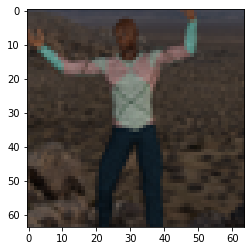

In [5]:
# periksa salah satu gambar
sample_image = labeled_images[-1]
print(sample_image[0].shape)
plt.imshow(sample_image[0])
print(f"Ini adalah gambar '{categories[sample_image[1]]}'")

In [6]:
def split(images_list):
    images, labels = zip(*images_list)
    # ubah images dan labels masing-masing menjadi array dan namakan X dan Y
    X = np.array(images)
    Y = np.array(labels)
    return X, Y  

train_set_x_orig, train_set_y = split(labeled_images)
train_set_x_orig

array([[[[ 22,  28,  33],
         [ 22,  28,  33],
         [ 22,  28,  33],
         ...,
         [242, 229, 209],
         [232, 219, 201],
         [233, 220, 201]],

        [[ 22,  28,  34],
         [ 22,  28,  34],
         [ 23,  28,  34],
         ...,
         [222, 210, 191],
         [218, 205, 187],
         [219, 206, 188]],

        [[ 23,  29,  35],
         [ 23,  29,  35],
         [ 23,  29,  36],
         ...,
         [211, 198, 180],
         [215, 202, 185],
         [219, 206, 188]],

        ...,

        [[167, 155, 139],
         [170, 159, 143],
         [173, 162, 145],
         ...,
         [205, 192, 173],
         [226, 212, 193],
         [217, 203, 184]],

        [[171, 159, 143],
         [169, 158, 142],
         [170, 159, 143],
         ...,
         [210, 197, 178],
         [204, 191, 173],
         [203, 191, 172]],

        [[166, 155, 139],
         [167, 156, 140],
         [174, 162, 146],
         ...,
         [160, 148, 132],
        

In [7]:
m_train = len(train_set_x_orig)
num_px = train_set_x_orig[0].shape[0]

print ("Number of training examples: m_train = " + str(m_train))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 4)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))

Number of training examples: m_train = 1027
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 4)
train_set_x shape: (1027, 64, 64, 3)
train_set_y shape: (1027,)


In [8]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T 
print(train_set_x_flatten[-1])
train_y = np.expand_dims(train_set_y, 0)

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_y.shape))

[140  40 104 ... 185 206  16]
train_set_x_flatten shape: (12288, 1027)
train_set_y shape: (1, 1027)


In [9]:
# normalize
train_x = train_set_x_flatten/255.

In [10]:
%%capture
!wget https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
!unzip \*.zip -d test  && rm *.zip;

In [11]:
test_set_x_orig, test_set_y = split(obtain_images_data('/content/test/'))
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
test_y = np.expand_dims(test_set_y, 0)
# normalize
test_x = test_set_x_flatten/255.

In [15]:
test_set_x_orig.shape
train_x.T.shape

(1027, 12288)

## Tugas

1. Buat dan latih ulang model NN pada praktikum 4 (klasifikasi gambar kuda dan manusia), dengan hidden layer yang custom dan tidak menggunakan konvolusi.

2. Buat dan latih model sembarang secara bebas, bisa RNN, CNN, dll. Untuk penggunaan layernya bisa baca di dokumentasi Tensorflow.

Catatan:
1. Gunakan Tensorflow Low-Level atau Mid-Level API (dilarang pakai Hi-Level!)
2. Kode harus dalam bentuk OOP

### Tugas 1 : Model DNN dengan Tensorflow

In [73]:
class DNN:
  def __init__(self, X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 1000):
    self.X, self.y = X, Y
    self.layers_dims = layers_dims
    self.lr = learning_rate
    self.num_iter = num_iterations

    w_init = tf.random_normal_initializer()
    b_init = tf.zeros_initializer()

    self.parameters = {}
    L = len(self.layers_dims)       
    
    #inisiasi model
    self.hidden_layer=[]
    for i in range(L):
      self.hidden_layer.append(tf.keras.layers.Dense(units=self.layers_dims[i], name='HL'+str(i), activation='relu'))
    
    self.output_layer = tf.keras.layers.Dense(units=1, name='OL', activation='sigmoid')

    # definisikan alur dari jaringannya
    self.output_HL=[]
    self.input = tf.keras.Input(tf.shape(self.X[0],), name='input')
    #input HL pertama
    self.output_HL.append(self.hidden_layer[0](self.input))
    #input HL kedua hingga terakhir
    for i in range(1, L):
      self.output_HL.append(self.hidden_layer[i](self.output_HL[i-1]))
    #input OL   
    self.output = self.output_layer(self.output_HL[-1])

    # definisikan jaringannya dengan input dan output
    self.network = tf.keras.Model(inputs=self.input, outputs=self.output)

  def train(self):

    # definsikan optimizer, kali ini akan digunakan Stochastic Gradient Descent
    optimizer = tf.keras.optimizers.SGD(lr=self.lr)
    # definisikan fungsi loss yang digunakan
    self.loss_fn = tf.keras.losses.BinaryCrossentropy()
    # definisikan metrik yang digunakan
    self.metric_fn = tf.keras.metrics.binary_accuracy 

    # iterasi
    self.costs=[]
    for i in range(self.num_iter):
        with tf.GradientTape() as tape:
            # forward propagation
            self.y_out = self.network(self.X, training=True)
            self.loss = self.loss_fn(self.y, self.y_out)
        # backward propagation
        grads = tape.gradient(self.loss, self.network.trainable_weights)
        # optimize
        optimizer.apply_gradients(zip(grads, self.network.trainable_weights))
        # hitung akurasi
        accuracy = self.metric_fn(self.y, self.y_out)
        # akurasi yang dihitung masih per data, jadi kita rata-rata dulu semuanya
        self.accuracy = tf.reduce_mean(accuracy)
        # cetak log
        if i % (self.num_iter // 10) == 0:
            print (f"Iteration {i} - Loss: {self.loss}; Acc: {self.accuracy*100}")
            self.costs.append(self.loss)

  def plot(self):
    plt.plot(np.squeeze(self.costs))
    plt.ylabel('cost')
    plt.xlabel('iterasi (per 100)')
    plt.title("Learning rate =" + str(self.lr))
    plt.show()

  def predict(self, x, y):
    #forward propagation
    with tf.GradientTape() as tape:
        # forward propagation
        y_out = self.network(x, training=True)
        p_loss = self.loss_fn(y, y_out)
    #hitung akurasi
    p_accuracy = tf.reduce_mean(self.metric_fn(y, y_out))


    print("Accuracy: "  + str(p_accuracy.numpy()*100) + " - Loss prediksi:  " + str(p_loss.numpy()))


Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 12288)]           0         
_________________________________________________________________
HL0 (Dense)                  (None, 20)                245780    
_________________________________________________________________
HL1 (Dense)                  (None, 7)                 147       
_________________________________________________________________
HL2 (Dense)                  (None, 5)                 40        
_________________________________________________________________
OL (Dense)                   (None, 1)                 6         
Total params: 245,973
Trainable params: 245,973
Non-trainable params: 0
_________________________________________________________________


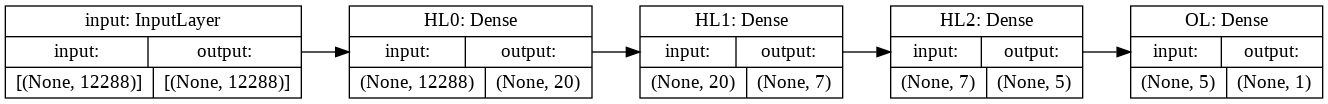

In [74]:
hidden_neurons = [20, 7, 5] # tentukan banyaknya layers dan banyaknya neuron di setiap hidden layer
layers_dims =  hidden_neurons 
DNN1 = DNN(train_x.T, train_y.T, layers_dims, learning_rate = 0.0075, num_iterations = 1001)
DNN1.network.summary()
tf.keras.utils.plot_model(DNN1.network, show_shapes=True, rankdir='LR')

Iteration 0 - Loss: 0.6981863379478455; Acc: 48.685489654541016
Iteration 100 - Loss: 0.5840833783149719; Acc: 65.72541809082031
Iteration 200 - Loss: 0.4318922758102417; Acc: 79.84420776367188
Iteration 300 - Loss: 0.35520511865615845; Acc: 83.64167022705078
Iteration 400 - Loss: 0.3019099235534668; Acc: 86.1733169555664
Iteration 500 - Loss: 0.25017619132995605; Acc: 89.67867279052734
Iteration 600 - Loss: 0.26932665705680847; Acc: 88.02336883544922
Iteration 700 - Loss: 0.14897261559963226; Acc: 95.6183090209961
Iteration 800 - Loss: 0.1595674753189087; Acc: 94.54722595214844
Iteration 900 - Loss: 0.14687517285346985; Acc: 97.56571960449219
Iteration 1000 - Loss: 0.08437372744083405; Acc: 98.14994812011719


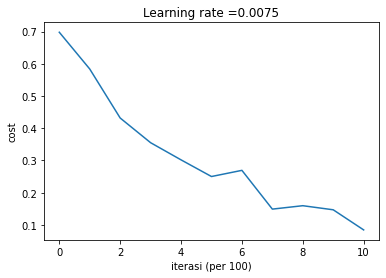

In [75]:
DNN1.train()
DNN1.plot()

In [76]:
DNN1.predict(test_x.T, test_y.T)

Accuracy: 88.28125 - Loss prediksi:  0.40513057


### Tugas 2 Model RNN dengan Tensorflow

Pada tugas 2 ini akan dibuat model RNN yang diberikan pada kelas kuliah dengan menggunakan library tensorflow

In [141]:
#menggunakan low level
class RNN:
  def __init__(self,x,nh,alpha,epochs):
    self.Xtrain  = x #input
    self.ytrain  = x[:,-1:] #output 
    self.nh = nh
    self.α= alpha
    self.epochs = epochs
    self.Ts = tf.shape(self.Xtrain)[1]-1   # Time-steps
    self.N, self.no = tf.shape(self.ytrain)     #jumlah observasi (self.N) dan jumlah output
    self.ni    = 1  #jumlah input

    "Inisialisasi param dabn b"
    init = tf.random_normal_initializer()
    self.w0 = tf.Variable(init(shape=(self.ni,self.nh), dtype='float32'))
    self.w1 = tf.Variable(init(shape=(self.nh,self.no), dtype='float32'))
    self.ws = tf.Variable(init(shape=(self.nh,self.nh), dtype='float32'))
    self.b0 = tf.Variable(init(shape=(1,self.nh), dtype='float32'))
    self.b1 = tf.Variable(init(shape=(1,self.no), dtype='float32'))

    print("Init param success")
    "Pendefinisian optimizer"
    self.optimizer = tf.keras.optimizers.SGD(lr=self.α)
    self.metric_fn = tf.keras.metrics.MeanSquaredError()
    self.zero_init = tf.zeros_initializer()

  def learning(self):
    "inisialisasi tensor hasil dan error"
    self.ycap = []

    with tf.GradientTape() as tape:
      for i in  range(len(self.Xtrain)):
        self.S1 = [tf.Variable(self.zero_init(shape=(self.ni,self.nh), dtype='float32'))]
        self.S2 = []

        "forward propagation"
        for k in range(self.Ts):
          "initial param"
          A0 = self.Xtrain[i,k]
          yk = self.Xtrain[i,k+1]
          "input to hidden layer"
          Z1 = A0 * self.w0 +self.b0 + tf.matmul(self.S1[-1], self.ws)
          A1 = tf.math.tanh(Z1)
          self.S1.append(tf.identity(A1))
          "hidden to output layer"
          Z2 = tf.matmul(A1, self.w1) + self.b1
          A2 = tf.nn.sigmoid(Z2)
          self.S2.append(tf.identity(A2))

        "append hasil pada variabel"
        self.ycap.append(A2[0])
        #print("forward selesai")
  
      self.cost = tf.keras.losses.MSE(self.ytrain, self.ycap)
      self.cost = tf.reduce_mean(self.cost)
      #print("cost dihitung")

    self.dw0, self.dw1,self.dws,self.db0, self.db1 = tape.gradient(self.cost, (self.w0,self.w1,self.ws,self.b0,self.b1))
    # optimize
    self.optimizer.apply_gradients(zip((self.dw0, self.dw1,self.dws,self.db0, self.db1), (self.w0,self.w1,self.ws,self.b0,self.b1)))
    # hitung akurasi
    #print("parameter berhasil diopitmisasi")
    #accuracy = self.metric_fn(self.train, self.ycap)
    # akurasi yang dihitung masih per data, jadi kita rata-rata dulu semuanya
    #print(self.cost)
    #self.accuracy = tf.reduce_mean(accuracy)

  def train(self):
    self.costs =[]
    self.accs = []
    for n in range(self.epochs):
      self.learning()

      if n % ((self.epochs-1)/5) == 0:
        self.costs.append(self.cost)
        #self.accs.append(self.accuracy)
        print(f"Epoch ke {n}, MSE sebesar: {self.cost:6.5f} ")
        
      #print(self.ycap.shape)
      #print(self.ytrain.shape)

    plt.plot(self.Xtrain[:, -1:], label = 'actual series')
    plt.plot(self.ycap, label = 'predicted series')
    plt.legend()
    plt.show()

  def test(self, Xtest, ytest):
    "inisialisasi tensor hasil dan error"
    ycap = []
    for i in  range(len(Xtest)):
      S1 = [tf.Variable(self.zero_init(shape=(self.ni,self.nh), dtype='float32'))]
      S2 = []

      "forward propagation"
      for k in range(self.Ts):
        "initial param"
        A0 = Xtest[i,k]
        yk = Xtest[i,k+1]
        "input to hidden layer"
        Z1 = A0 * self.w0 +self.b0 + tf.matmul(self.S1[-1], self.ws)
        A1 = tf.math.tanh(Z1)
        S1.append(tf.identity(A1))
        "hidden to output layer"
        Z2 = tf.matmul(A1, self.w1) + self.b1
        A2 = tf.nn.sigmoid(Z2)
        S2.append(tf.identity(A2))

      "append hasil pada variabel"
      ycap.append(A2[0])
      #print("forward selesai")
  
    cost = tf.keras.losses.MSE(ytest, ycap)
    cost = tf.reduce_mean(cost)
    print('\n\nMSE testing : %7.7f'%cost)
          
    plt.plot(ytest, label = 'actual series')
    plt.plot(ycap, label = 'predicted series')
    plt.legend()
    plt.show()    



In [62]:
"Time step (ts)"
def steps(x, step):   
    obs  = len(x)-step
    xt   = x[:obs,:]
    for i in np.arange(1,step+1):
        xt = np.hstack((xt, x[i:obs+i,:]))   
    return xt
"Pengisian nilai kosong atau missing value pada data"
 #Data time series harian harga saham Bank Mandiri sejak 02 Januari 2015
A  = pd.read_csv('/content/BMRI.JK.csv') 
A_fillna = A['Adj Close']
A_fillna[A_fillna.isnull()]
A_fillna[1127] = (A_fillna[1126]+A_fillna[1128])*0.5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [63]:
"Pembagian data latih dan data uji"
A6 = A_fillna.values   #Ambil kolom ke enam berisi 'Adj Close', 
B  = A6[:,np.newaxis]  
                                     
Bmin = min(B)
Bmax = max(B)
b = (B-Bmin)/(Bmax-Bmin)

ts = 1   #Di literatur Time Series digunakan istilah 'lag' sebagai padanan istilah 'timestep' ini
xs = steps(b, ts)  #Dihasilkan matriks dengan 2 (= ts+1) kolom, kolom pertama menjadi variabel X
                   #dan kolom terkhir menjadi variabel 
x = xs[-800:,:]    #Ambil 800 observasi terakhir

#Data untuk training
Xtrain = x[0:680,:]   #Ambil 680 observasi yang pertama dan hilangkan kolom terakhir
ytrain = x[0:680:, -1:]  #Ambil 680 observasi yang pertama dan ambil kolom terakhir sebagai variabel y 

#Data untuk testing
Xtest = x[680:, :]   #ambil jumlah observasi sebanyak 120, hilangkan kolom terakhir (untuk y)
ytest = x[680:, -1:] #ambil kolom terakhir

Init param success
Epoch ke 0, MSE sebesar: 0.07717 
Epoch ke 16, MSE sebesar: 0.02951 
Epoch ke 32, MSE sebesar: 0.02401 
Epoch ke 48, MSE sebesar: 0.01085 
Epoch ke 64, MSE sebesar: 0.00277 
Epoch ke 80, MSE sebesar: 0.00143 


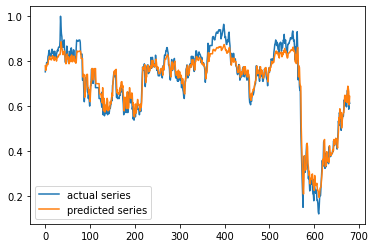

In [147]:
#Ringkasan nh = 3, alpha = 0.27 epochs = 36, ts = 1

nh     = 3  
alpha  = 5
epochs = 81

"Training"
tf.random.set_seed(7399)
rnn1 = RNN(Xtrain,nh,alpha,epochs)
rnn1.train()



MSE testing : 0.0012612


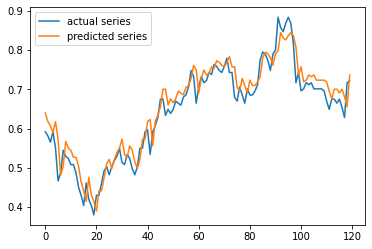

In [148]:
rnn1.test(Xtest, ytest)